In [4]:
# import seaborn as sns
import re
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import sklearn
from scipy.sparse import vstack
from scipy.special import expit
from scipy.stats import pearsonr, spearmanr
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import accuracy_score, auc, classification_report, roc_curve
from sklearn.model_selection import (
    # LearningCurveDisplay,
    # learning_curve,
    train_test_split,
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics._dist_metrics import DistanceMetric
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [5]:
# adata -> output of preprocessing (in theory)
file = "/home/jkuhn/Bachelors-Thesis/input/CountAdded_PIP_global_object_for_cellxgene1.h5ad"
adata_all = sc.read_h5ad(file)
adata_all.var_names_make_unique()
adata_all

AnnData object with n_obs × n_vars = 329762 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

# One hot encoding

In [6]:
encoder_organ = LabelEncoder()
y_encoded = encoder_organ.fit_transform(adata_all.obs["Organ"])  # encode the organ labels

In [7]:
# Replace the existing 'Organ' column with the encoded labels
adata_all.obs["Organ"] = y_encoded

In [8]:
label_table = pd.DataFrame(
    {
        "Encoded_Label": encoder_organ.transform(encoder_organ.classes_),
        "Decoded_Label": encoder_organ.classes_,
    }
)

# Print the table
print(label_table)

    Encoded_Label Decoded_Label
0               0           BLD
1               1           BMA
2               2           CAE
3               3           DUO
4               4           ILE
5               5        JEJEPI
6               6         JEJLP
7               7           LIV
8               8           LLN
9               9           LNG
10             10           MLN
11             11           OME
12             12           SCL
13             13           SKM
14             14           SPL
15             15           TCL
16             16           THY


### Subsetting the dataset: 

In [9]:
celltype = "T cells"

In [10]:
adata = adata_all[(adata_all.obs["Majority_voting_CellTypist_high"] == celltype)]

In [11]:
adata

View of AnnData object with n_obs × n_vars = 183796 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [ ]:
# split for each chem and organ for this celltype into train and test
def ttsplit(celltype: str) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    count = 0

    subset_celltype = adata[(adata.obs["Majority_voting_CellTypist_high"] == celltype)]

    for chem in subset_celltype.obs["Chemistry"].unique():
        subset_chemistry = subset_celltype[
                (subset_celltype.obs["Chemistry"] == chem)
            ]

        for organ in subset_chemistry.obs["Organ"].unique():

            subset_organ = subset_chemistry[(subset_chemistry.obs["Organ"] == organ)]
            X = subset_organ.to_df()
            y = subset_organ.obs["Organ"]
            subset_name = f"{celltype}_{organ}_{chem}"
    
            try:
                if count != 0:
                    X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
                        X, y, test_size=0.2, random_state=42
                    )

                    X_test = pd.concat([X_test, X_test_pre])
                    X_train = pd.concat([X_train, X_train_pre])
                    y_test = pd.concat([y_test, y_test_pre])
                    y_train = pd.concat([y_train, y_train_pre])
                    count = count + 1

                else:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=42
                    )
                    count = count + 1

            except ValueError as e:

                num_elements = X.shape[0]

                if num_elements == 1: 
                    X_train_pre, X_test_pre, y_train_pre, y_test_pre = X, None, y, None

                    X_test = pd.concat([X_test, X_test_pre])
                    X_train = pd.concat([X_train, X_train_pre])
                    y_test = pd.concat([y_test, y_test_pre])
                    y_train = pd.concat([y_train, y_train_pre])

                else:
                    print(f"Subset with name '{subset_name}' caused an error: {e}")

                continue 
    return X_train, X_test, y_train, y_test

In [16]:
def save_model(bst: xgb.Booster, modelname: str):
    print("modelname: " + model_name)
    # save model
    bst.save_model(model_name)

In [18]:
def load_model(modelname: str) -> xgb.Booster:
    bst = xgb.Booster()
    bst.load_model(modelname)
    return bst

In [ ]:
def prediction(bst: xgb.Booster) -> pd.DataFrame: # gets model and returns classification report, y_pred_encoded oder adata mit prediction
    y_pred_prob = bst.predict(dtest) # predict
    y_pred_encoded = np.argmax(y_pred_prob, axis =1)

    accuracy = accuracy_score(y_test, y_pred_encoded)
    print(f"Accuracy: {accuracy}")
    
    y_test_decoded = encoder_organ.inverse_transform(
        y_test
    ) 
    y_pred_encoded_series = pd.Series(y_pred_encoded)

    # Map the encoded labels to decoded labels using the label table DataFrame
    y_pred = y_pred_encoded_series.map(
        dict(zip(label_table["Encoded_Label"], label_table["Decoded_Label"]))
    )

    class_report = metrics.classification_report(y_test, y_pred_encoded)

    print("Classification Report for celltype: ", celltype)
    print(class_report)

    with open(report_name, "a") as f:
        print("Classification Report for celltype:", celltype, file=f)
        print(class_report, file=f)

    result_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_encoded})

    actual_counts = result_df["Actual"].value_counts()
    predicted_counts = result_df["Predicted"].value_counts()
    combined_counts = pd.concat([actual_counts, predicted_counts], axis=1)
    combined_counts.columns = ["Actual", "Predicted"]
    combined_counts = combined_counts.fillna(0)  # Fill NaN values with 0

    # Plot the distributions
    combined_counts.plot(kind="bar", figsize=(12, 6))
    plt.title("Distribution of Actual and Predicted Categories for " + celltype)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(["Actual", "Predicted"])
    plt.show()

    return y_pred_encoded

In [21]:
X_train, X_test, y_train, y_test = ttsplit(celltype) 
X = adata.to_df()
y = adata.obs["Organ"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [19]:
num_classes = len(encoder_organ.classes_)
print("Number of classes:", num_classes)
class_names = encoder_organ.classes_
model_number = "0005"
report_name = f"{model_number}_classification_report.txt"

Number of classes: 17


In [ ]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    "num_class": num_classes,
    # Other parameters
    "objective": "multi:softprob",
    "eval_metric": ['merror','mlogloss'], 
    'device': 'cuda'
}

# Parameter Tuning
Here, the following tutorial was adapted: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

### Parameters num_boost_round and early_stopping_rounds

In [22]:
# train model with that
evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=10,
    evals_result = evals_result
)
print("Best merror: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[16:25:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/context.cc:44: No visible GPU is found, setting device to CPU.


[0]	train-merror:0.35017	train-mlogloss:1.83905	eval-merror:0.35872	eval-mlogloss:1.86016
[1]	train-merror:0.31314	train-mlogloss:1.53788	eval-merror:0.32794	eval-mlogloss:1.56997
[2]	train-merror:0.29094	train-mlogloss:1.34015	eval-merror:0.30964	eval-mlogloss:1.38060
[3]	train-merror:0.27336	train-mlogloss:1.19307	eval-merror:0.29517	eval-mlogloss:1.24162
[4]	train-merror:0.26097	train-mlogloss:1.08257	eval-merror:0.28625	eval-mlogloss:1.13804
[5]	train-merror:0.25043	train-mlogloss:0.99296	eval-merror:0.27709	eval-mlogloss:1.05478
[6]	train-merror:0.23941	train-mlogloss:0.91749	eval-merror:0.26751	eval-mlogloss:0.98488
[7]	train-merror:0.23204	train-mlogloss:0.85751	eval-merror:0.26205	eval-mlogloss:0.93001
[8]	train-merror:0.22388	train-mlogloss:0.80679	eval-merror:0.25636	eval-mlogloss:0.88402
[9]	train-merror:0.21571	train-mlogloss:0.76066	eval-merror:0.24937	eval-mlogloss:0.84258
[10]	train-merror:0.20808	train-mlogloss:0.72067	eval-merror:0.24375	eval-mlogloss:0.80677
[11]	trai

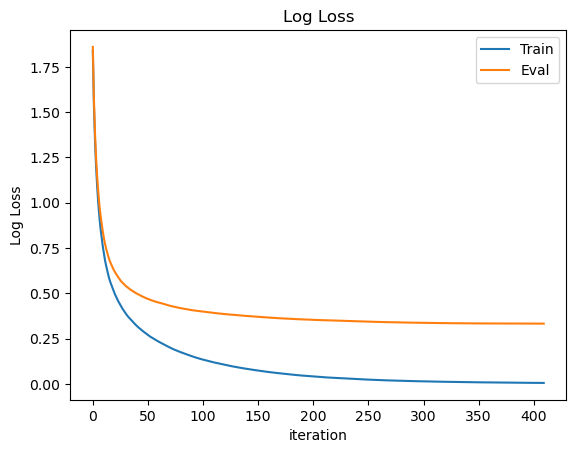

In [23]:
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
ax.plot(x_axis, evals_result['eval']['mlogloss'], label='Eval')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('iteration')
plt.title('Log Loss')
plt.show()

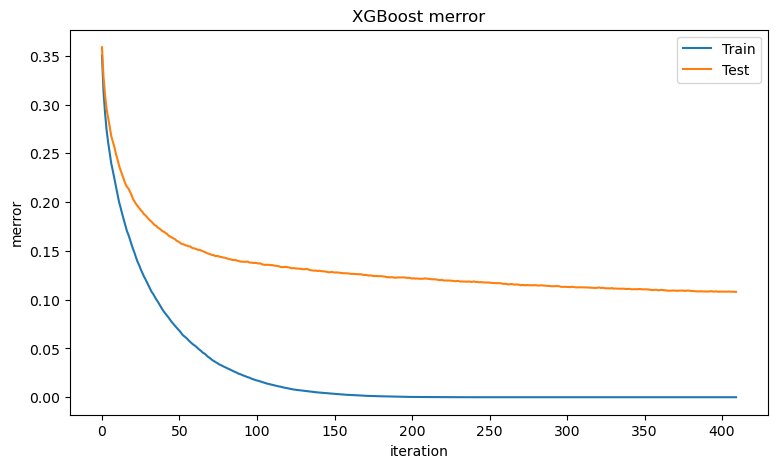

In [24]:
# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, evals_result['train']['merror'], label='Train')
ax.plot(x_axis, evals_result['eval']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.xlabel('iteration')
plt.title('XGBoost merror')
plt.show()

In [25]:
# saving that 
evals_result = {}

num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    evals_result = evals_result
)

[02:49:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/context.cc:44: No visible GPU is found, setting device to CPU.


[0]	Test-merror:0.35872	Test-mlogloss:1.86016
[1]	Test-merror:0.32794	Test-mlogloss:1.56997
[2]	Test-merror:0.30964	Test-mlogloss:1.38060
[3]	Test-merror:0.29517	Test-mlogloss:1.24162
[4]	Test-merror:0.28625	Test-mlogloss:1.13804
[5]	Test-merror:0.27709	Test-mlogloss:1.05478
[6]	Test-merror:0.26751	Test-mlogloss:0.98488
[7]	Test-merror:0.26205	Test-mlogloss:0.93001
[8]	Test-merror:0.25636	Test-mlogloss:0.88402
[9]	Test-merror:0.24937	Test-mlogloss:0.84258
[10]	Test-merror:0.24375	Test-mlogloss:0.80677
[11]	Test-merror:0.23752	Test-mlogloss:0.77476
[12]	Test-merror:0.23241	Test-mlogloss:0.74841
[13]	Test-merror:0.22835	Test-mlogloss:0.72573
[14]	Test-merror:0.22359	Test-mlogloss:0.70412
[15]	Test-merror:0.21922	Test-mlogloss:0.68457
[16]	Test-merror:0.21587	Test-mlogloss:0.66918
[17]	Test-merror:0.21402	Test-mlogloss:0.65572
[18]	Test-merror:0.21065	Test-mlogloss:0.64153
[19]	Test-merror:0.20747	Test-mlogloss:0.62880
[20]	Test-merror:0.20328	Test-mlogloss:0.61777
[21]	Test-merror:0.2005

In [26]:
best_model.save_model("bestT_softprob.model")

[12:44:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [2]:
# use model later: 
loaded_model = xgb.Booster()
loaded_model.load_model("bestT_softprob.model")

training done
Accuracy: 0.8916838899162406
Classification Report for celltype:  T cells
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3271
           1       0.93      0.90      0.91      4059
           2       0.83      0.38      0.52        40
           3       0.96      0.93      0.94       128
           4       0.91      0.86      0.89       139
           5       0.89      0.90      0.90      5264
           6       0.87      0.83      0.85      3458
           7       0.88      0.86      0.87      1200
           8       0.89      0.93      0.91      8814
           9       0.92      0.70      0.80      1075
          10       0.85      0.86      0.85      3134
          11       0.95      0.57      0.71        70
          12       0.50      0.07      0.12        15
          13       0.90      0.76      0.83        84
          14       0.87      0.89      0.88      5939
          15       0.45      0.20      0.28    

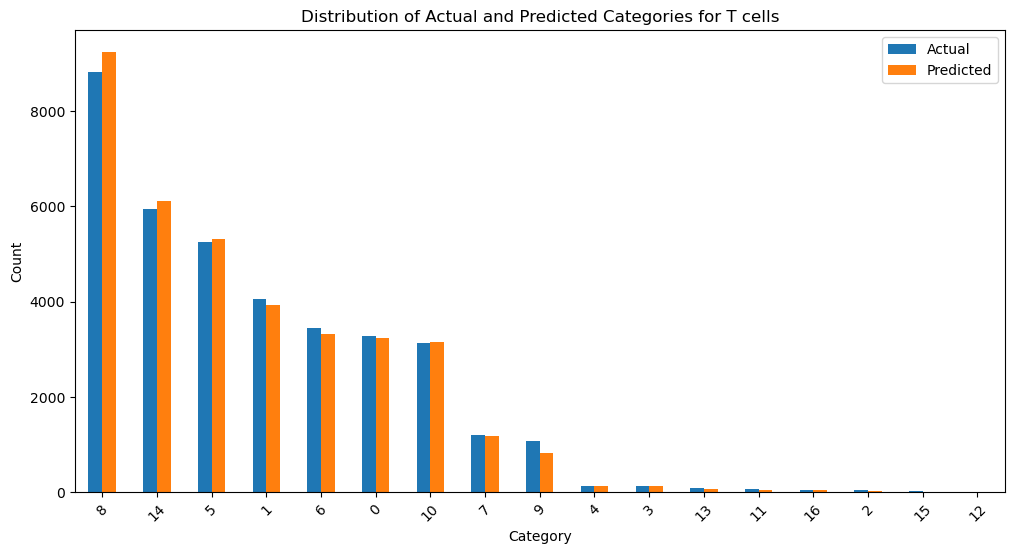

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [22]:
print("training done")
y_pred_encoded = prediction(loaded_model) # predict
y_pred_encoded = loaded_model.predict(dtest)
    
accuracy = accuracy_score(y_test, y_pred_encoded)
print ("SCORE:", accuracy)

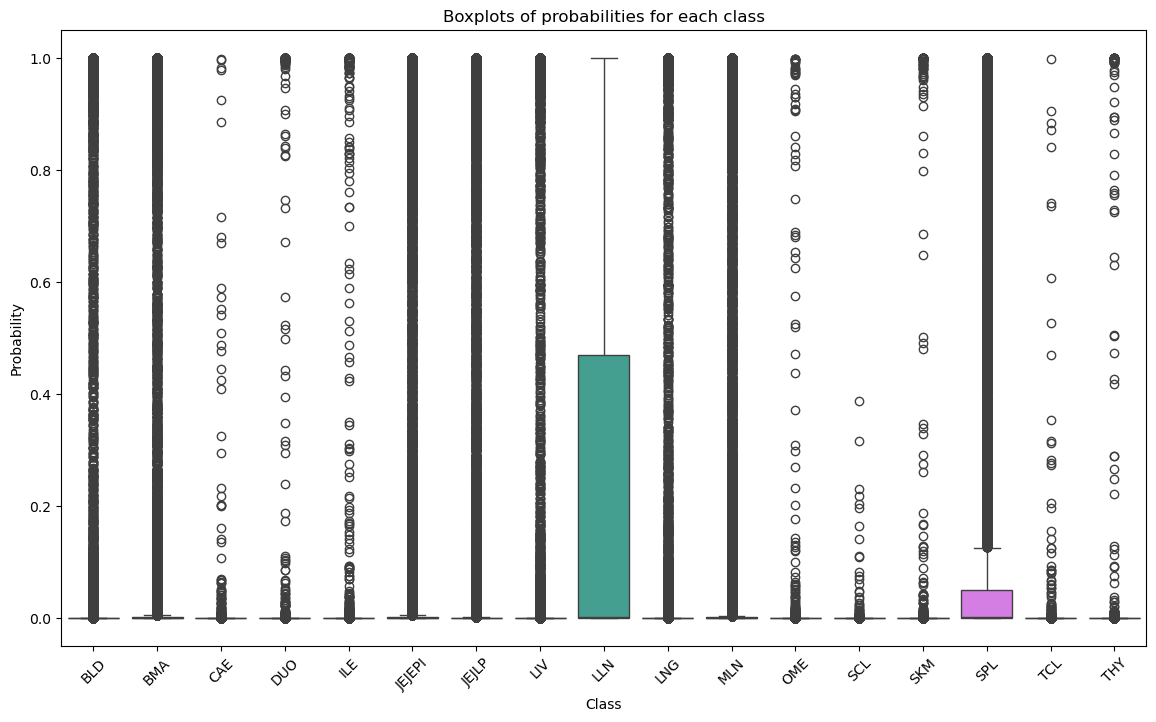

In [27]:
# Convert class indices to class labels
class_labels = label_table['Decoded_Label'].tolist()
df = pd.DataFrame(y_pred_prob, columns=class_labels)

# Boxplot for each class
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Boxplots of probabilities for each class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

# Feature importance scores

In [ ]:
feature_names = adata.var_names.tolist()

# Create a dictionary mapping feature indices to feature names
feature_index_to_name = {index: name for index, name in enumerate(feature_names)}

# Example feature importance scores from an XGBoost model
importance_scores = loaded_model.get_score(importance_type="weight")
sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# Map feature indices to feature names and print them
for feature, score in sorted_features[:25]:
    feature_index_match = re.search(r"\d+", feature)
    if feature_index_match:
        feature_index = int(feature_index_match.group())
        feature_name = feature_index_to_name.get(feature_index, "Unknown")
        print(f"Feature {feature} is gene {feature_name} and has importance score: {score}")

# Visualize feature importance with feature names instead of numbers
sorted_features_with_names = [(feature_index_to_name[int(re.search(r"\d+", feature[0]).group())], feature[1]) for feature in sorted_features]

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_features_with_names)),
    [feature[1] for feature in sorted_features_with_names],
    tick_label=[feature[0] for feature in sorted_features_with_names],  # Use feature names instead of numbers
)
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.title("Feature Importance")
plt.yticks(rotation=0)
plt.show()

# Limit to the Top 40 features
top_features = sorted_features_with_names[:40]

# Visualize feature importance for the top 40 features
plt.figure(figsize=(10, 6))
plt.bar(
    range(len(top_features)),
    [feature[1] for feature in top_features],
    tick_label=[feature[0] for feature in top_features]  # Use feature names instead of numbers
)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Top 40 Features by Importance")
plt.xticks(rotation=90)
plt.show()

Feature f6788 is gene MTRNR2L12 and has importance score: 1344.0
Feature f36563 is gene MT-ATP8 and has importance score: 1284.0
Feature f21898 is gene RPS26 and has importance score: 1063.0
Feature f31591 is gene JUND and has importance score: 959.0
Feature f36450 is gene RPS4Y1 and has importance score: 729.0
Feature f36564 is gene MT-ATP6 and has importance score: 721.0
Feature f19107 is gene HBB and has importance score: 672.0
Feature f24894 is gene HSP90AA1 and has importance score: 636.0
Feature f31445 is gene DNAJB1 and has importance score: 631.0
Feature f31504 is gene KLF2 and has importance score: 630.0
Feature f1853 is gene TXNIP and has importance score: 622.0
Feature f20003 is gene MALAT1 and has importance score: 602.0
Feature f11718 is gene HSPA1B and has importance score: 575.0
Feature f1182 is gene JUN and has importance score: 572.0
Feature f11717 is gene HSPA1A and has importance score: 563.0
Feature f11000 is gene DUSP1 and has importance score: 561.0
Feature f36561

# Prediction on Exercise Dataset

In [22]:
file = "adata_final.h5ad"
print("reading file")
adata2 = sc.read_h5ad(file)
modelname = "T cells"

reading file


In [23]:
bst = xgb.Booster()
bst.load_model("bestT_softprob.model")

In [24]:
subset = adata2[(adata2.obs["celltypist_cell_label_coarse"] == "T cells")]
X = subset.to_df()
deval = xgb.DMatrix(X) 

In [29]:
y_pred_prob_ex = loaded_model.predict(deval) # predict
predictions = np.argmax(y_pred_prob_ex, axis =1)

In [38]:
label_mapping = {
            0: 'BLD',
            1: 'BMA',
            2: 'CAE',
            3: 'DUO',
            4: 'ILE',
            5: 'JEJEPI',
            6: 'JEJLP',
            7: 'LIV',
            8: 'LLN',
            9: 'LNG',
            10: 'MLN',
            11: 'OME',
            12: 'SCL',
            13: 'SKM',
            14: 'SPL',
            15: 'TCL',
            16: 'THY'
}

In [36]:
# Add predictions to the subset
subset.obs["Predicted_tissue"] = [label_mapping[int(pred)] for pred in predictions]
subset.obs["celltype_model"] = modelname

Trying to modify attribute `.obs` of view, initializing view as actual.


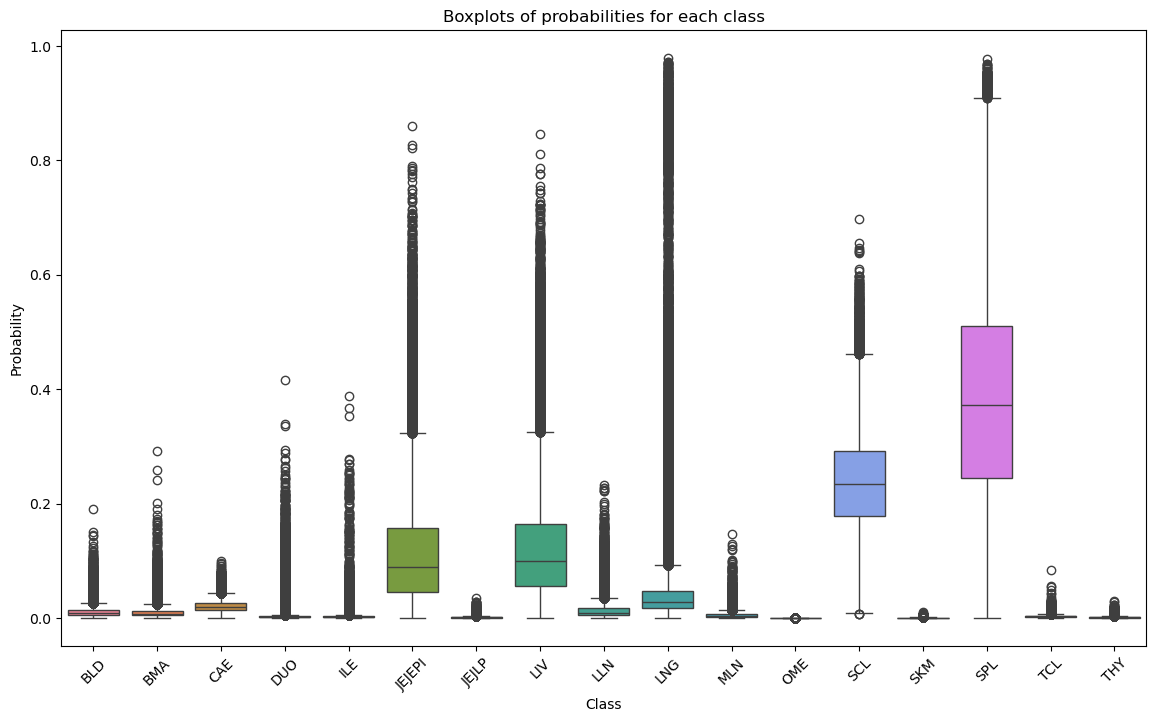

In [37]:
# Convert class indices to class labels
class_labels = [label_mapping[i] for i in range(y_pred_prob_ex.shape[1])]
df = pd.DataFrame(y_pred_prob_ex, columns=class_labels)

# Boxplot for each class
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Boxplots of probabilities for each class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

In [40]:
# Extract 'timepoint' and 'Predicted_tissue' columns
data = {
    'timepoint': subset.obs['timepoint'],
    'Predicted_tissue': subset.obs['Predicted_tissue']
}
df = pd.DataFrame(data)

df = pd.DataFrame(data)

# Group by timepoint and calculate predicted tissue value counts for each timepoint
predicted_tissue_counts_by_timepoint = df.groupby('timepoint')['Predicted_tissue'].value_counts()

# Print the predicted tissue value counts for each timepoint
for timepoint, counts in predicted_tissue_counts_by_timepoint.groupby(level=0):
    print(f"Timepoint {timepoint}:")
    for tissue, count in counts.items():
        print(f"{tissue}\t{count}")
    print()


Timepoint 5b:
('5b', 'SPL')	13725
('5b', 'SCL')	4042
('5b', 'LIV')	1427
('5b', 'JEJEPI')	1275
('5b', 'LNG')	944
('5b', 'ILE')	3
('5b', 'DUO')	1
('5b', 'LLN')	1
('5b', 'BMA')	0

Timepoint 5a:
('5a', 'SPL')	13335
('5a', 'SCL')	3818
('5a', 'LIV')	1269
('5a', 'JEJEPI')	1085
('5a', 'LNG')	833
('5a', 'DUO')	3
('5a', 'ILE')	2
('5a', 'BMA')	1
('5a', 'LLN')	0

Timepoint 30a:
('30a', 'SPL')	14649
('30a', 'SCL')	4532
('30a', 'LIV')	1509
('30a', 'JEJEPI')	1301
('30a', 'LNG')	955
('30a', 'DUO')	1
('30a', 'ILE')	1
('30a', 'LLN')	0
('30a', 'BMA')	0

Timepoint 120a:
('120a', 'SPL')	470
('120a', 'SCL')	162
('120a', 'LIV')	56
('120a', 'JEJEPI')	38
('120a', 'LNG')	13
('120a', 'LLN')	0
('120a', 'ILE')	0
('120a', 'DUO')	0
('120a', 'BMA')	0



# Testing prediction using a split

In [23]:
first = True
for person in subset.obs["participant"].unique():
    print(person)
    sub_person = subset[subset.obs["participant"] == person]

    for tp in sub_person.obs["timepoint"].unique(): 
        print(tp)
        
        sub = sub_person[sub_person.obs["timepoint"] == tp]

        X = sub.to_df()
        deval = xgb.DMatrix(X) 
        
        y_pred_prob_ex = bst.predict(deval)
        predictions = np.argmax(y_pred_prob_ex, axis =1)
        
        sub.obs["Predicted_tissue"] = [label_mapping[int(pred)] for pred in predictions]
        sub.obs["celltype_model"] = modelname

        if first:
            combined_adata = sub.copy()
            first = False
        else:
            combined_adata = anndata.concat([combined_adata, sub], axis=0)


P3
120a


Trying to modify attribute `.obs` of view, initializing view as actual.


copy
5a


Trying to modify attribute `.obs` of view, initializing view as actual.


5b


Trying to modify attribute `.obs` of view, initializing view as actual.


30a


Trying to modify attribute `.obs` of view, initializing view as actual.


P1
120a


Trying to modify attribute `.obs` of view, initializing view as actual.


5b


Trying to modify attribute `.obs` of view, initializing view as actual.


30a


Trying to modify attribute `.obs` of view, initializing view as actual.


5a


Trying to modify attribute `.obs` of view, initializing view as actual.


P2
30a


Trying to modify attribute `.obs` of view, initializing view as actual.


5b


Trying to modify attribute `.obs` of view, initializing view as actual.


5a


Trying to modify attribute `.obs` of view, initializing view as actual.


P7
30a


Trying to modify attribute `.obs` of view, initializing view as actual.


5b


Trying to modify attribute `.obs` of view, initializing view as actual.


5a


Trying to modify attribute `.obs` of view, initializing view as actual.


P9
5b


Trying to modify attribute `.obs` of view, initializing view as actual.


30a


Trying to modify attribute `.obs` of view, initializing view as actual.


5a


Trying to modify attribute `.obs` of view, initializing view as actual.


P4
30a


Trying to modify attribute `.obs` of view, initializing view as actual.


5b


Trying to modify attribute `.obs` of view, initializing view as actual.


5a


Trying to modify attribute `.obs` of view, initializing view as actual.


P5
5a


Trying to modify attribute `.obs` of view, initializing view as actual.


5b


Trying to modify attribute `.obs` of view, initializing view as actual.


30a


Trying to modify attribute `.obs` of view, initializing view as actual.


P6
5b


Trying to modify attribute `.obs` of view, initializing view as actual.


5a


Trying to modify attribute `.obs` of view, initializing view as actual.


30a


Trying to modify attribute `.obs` of view, initializing view as actual.


In [26]:
# Extract 'timepoint' and 'Predicted_tissue' columns into a pandas DataFrame
data = {
    'timepoint': combined_adata.obs['timepoint'],
    'Predicted_tissue': combined_adata.obs['Predicted_tissue']
}
df = pd.DataFrame(data)

df = pd.DataFrame(data)

# Group by timepoint and calculate predicted tissue value counts for each timepoint
predicted_tissue_counts_by_timepoint = df.groupby('timepoint')['Predicted_tissue'].value_counts()

# Print the predicted tissue value counts for each timepoint
for timepoint, counts in predicted_tissue_counts_by_timepoint.groupby(level=0):
    print(f"Timepoint {timepoint}:")
    for tissue, count in counts.items():
        print(f"{tissue}\t{count}")
    print()

Timepoint 120a:
('120a', 'SPL')	470
('120a', 'SCL')	162
('120a', 'LIV')	56
('120a', 'JEJEPI')	38
('120a', 'LNG')	13

Timepoint 30a:
('30a', 'SPL')	14649
('30a', 'SCL')	4532
('30a', 'LIV')	1509
('30a', 'JEJEPI')	1301
('30a', 'LNG')	955
('30a', 'ILE')	1
('30a', 'DUO')	1

Timepoint 5a:
('5a', 'SPL')	13335
('5a', 'SCL')	3818
('5a', 'LIV')	1269
('5a', 'JEJEPI')	1085
('5a', 'LNG')	833
('5a', 'DUO')	3
('5a', 'ILE')	2
('5a', 'BMA')	1

Timepoint 5b:
('5b', 'SPL')	13725
('5b', 'SCL')	4042
('5b', 'LIV')	1427
('5b', 'JEJEPI')	1275
('5b', 'LNG')	944
('5b', 'ILE')	3
('5b', 'DUO')	1
('5b', 'LLN')	1

